In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

In [2]:
dataset_path = "../../dataset"
preprocessed_dataset_path = "preprocessed_dataset/"

In [3]:
from codes.docs.analysis import data_preprocessing, data_exploration, visualisation

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import nibabel as nib

## Imperial atlas

In [5]:
Imperial_label = pd.read_excel(open(
    f'{dataset_path}/volumetric/full_dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx',
    'rb'),
                               sheet_name='IMPERIAL ROIs LEGEND',
                               header=None).drop([0,1],axis=1)
Imperial_label.to_csv('./Imperial_label.txt',index=False,header=False)

In [6]:
Imperial_label = pd.read_csv('./Imperial_label.txt',header=None)
Imperial_label = Imperial_label.iloc[:,0].to_list()

In [7]:
from collections import defaultdict

Imperial_label_dict = defaultdict(dict)

for connection in Imperial_label:
    number = int([i for i in connection.split(' ') if i.isdigit()][0]) # get the number
    temp_connection = connection.strip(str(number)).strip()
    if 'left' in temp_connection:
        Imperial_label_dict[number]['Orientation'] = 'left'
        temp_connection = temp_connection.replace('left','').strip()
    elif 'right' in temp_connection:
        Imperial_label_dict[number]['Orientation'] = 'right'
        temp_connection = temp_connection.replace('right','').strip()
    else:
        Imperial_label_dict[number]['Orientation'] = 'None'
    if 'GM' in temp_connection:
        Imperial_label_dict[number]['matter'] = 'GM'
        temp_connection = temp_connection.replace('GM','').strip()
    elif 'WM' in temp_connection:
        Imperial_label_dict[number]['matter'] = 'WM'
        temp_connection = temp_connection.replace('WM','').strip()
    else:
        Imperial_label_dict[number]['matter'] = 'None'
    temp_connection = temp_connection.split(' ')
    try:
        part_index = temp_connection.index('part')
        Imperial_label_dict[number]['part'] = temp_connection[part_index-1]
        temp_connection.remove(temp_connection[part_index-1])
        temp_connection.remove('part')
    except ValueError:
        Imperial_label_dict[number]['part'] = 'None'
    temp_connection = ' '.join(temp_connection)
    Imperial_label_dict[number]['Name'] = temp_connection.strip()
    if Imperial_label_dict[number]['Name'][-1] == ',':
        Imperial_label_dict[number]['Name'] = temp_connection.replace(',','')
    
    if len(Imperial_label_dict[number]['Name'].split(' ')) > 1:
        Imperial_label_dict[number]['abbr'] = ''.join([word[0] for word in Imperial_label_dict[number]['Name'].split(' ')]).upper()
    else:
        Imperial_label_dict[number]['abbr'] = Imperial_label_dict[number]['Name'][:4].upper()
    
    if Imperial_label_dict[number]['matter'] != 'None':
        Imperial_label_dict[number]['Name_and_matter'] = '.'.join([Imperial_label_dict[number]['abbr'],Imperial_label_dict[number]['matter']])
    else:
        Imperial_label_dict[number]['Name_and_matter'] = Imperial_label_dict[number]['abbr']
        
    
    if Imperial_label_dict[number]['part']!= 'None':
        Imperial_label_dict[number]['abbr'] = ' '.join([Imperial_label_dict[number]['part'],Imperial_label_dict[number]['abbr']])
    if Imperial_label_dict[number]['matter'] != 'None':
        Imperial_label_dict[number]['abbr'] = '.'.join([Imperial_label_dict[number]['abbr'],Imperial_label_dict[number]['matter']])
        
    if Imperial_label_dict[number]['Orientation'] != 'None':
        Imperial_label_dict[number]['abbr'] = '.'.join([Imperial_label_dict[number]['Orientation'][0].upper(),Imperial_label_dict[number]['abbr']])
        Imperial_label_dict[number]['Name_and_matter'] = '.'.join([Imperial_label_dict[number]['Orientation'][0].upper(),Imperial_label_dict[number]['Name_and_matter']])
        
Imperial_label_dict_regions = [Imperial_label_dict[number]['abbr'] for number in range(1,88)]

In [8]:
# white_matter_labels       = 51..82              # tissues: 3
# gray_matter_labels        = 5..16,20..39        # tissues: 2
# deep_gray_matter_labels   = 1..4,40..47,85..87  # tissues: 5,7,9
# lateral_ventricles_labels = 49,50
# corpus_callosum_labels    = 48
# inter_hemisphere_labels   = 40..47,85..87
# brainstem_labels          = 19
# cerebellum_labels         = 17,18


In [11]:
white_matter_labels = list(range(51,83))
grey_matter_labels = list(range(5,17)) + list(range(20,40))
deep_grey_matter_labels = list(range(1,5)) + list(range(40,48)) + list(range(85,88))
lateral_ventricles_labels = [49,50]
corpus_callosum_labels = [48]
brainstem_labels = [19]
cerebellum_labels = [17,18]
csf_labels = [83]
background_labels = [84,85]
interhemispheric_labels = list(range(40,48)) + list(range(85,88))

In [11]:
Imperial_label_dict

defaultdict(dict,
            {1: {'Orientation': 'left',
              'matter': 'None',
              'part': 'None',
              'Name': 'Hippocampus',
              'abbr': 'L.HIPP',
              'Name_and_matter': 'L.HIPP'},
             2: {'Orientation': 'right',
              'matter': 'None',
              'part': 'None',
              'Name': 'Hippocampus',
              'abbr': 'R.HIPP',
              'Name_and_matter': 'R.HIPP'},
             3: {'Orientation': 'left',
              'matter': 'None',
              'part': 'None',
              'Name': 'Amygdala',
              'abbr': 'L.AMYG',
              'Name_and_matter': 'L.AMYG'},
             4: {'Orientation': 'right',
              'matter': 'None',
              'part': 'None',
              'Name': 'Amygdala',
              'abbr': 'R.AMYG',
              'Name_and_matter': 'R.AMYG'},
             5: {'Orientation': 'left',
              'matter': 'GM',
              'part': 'medial',
              'Name': 'A

In [10]:
label_legend={label:value['abbr'] for label,value in Imperial_label_dict.items()}

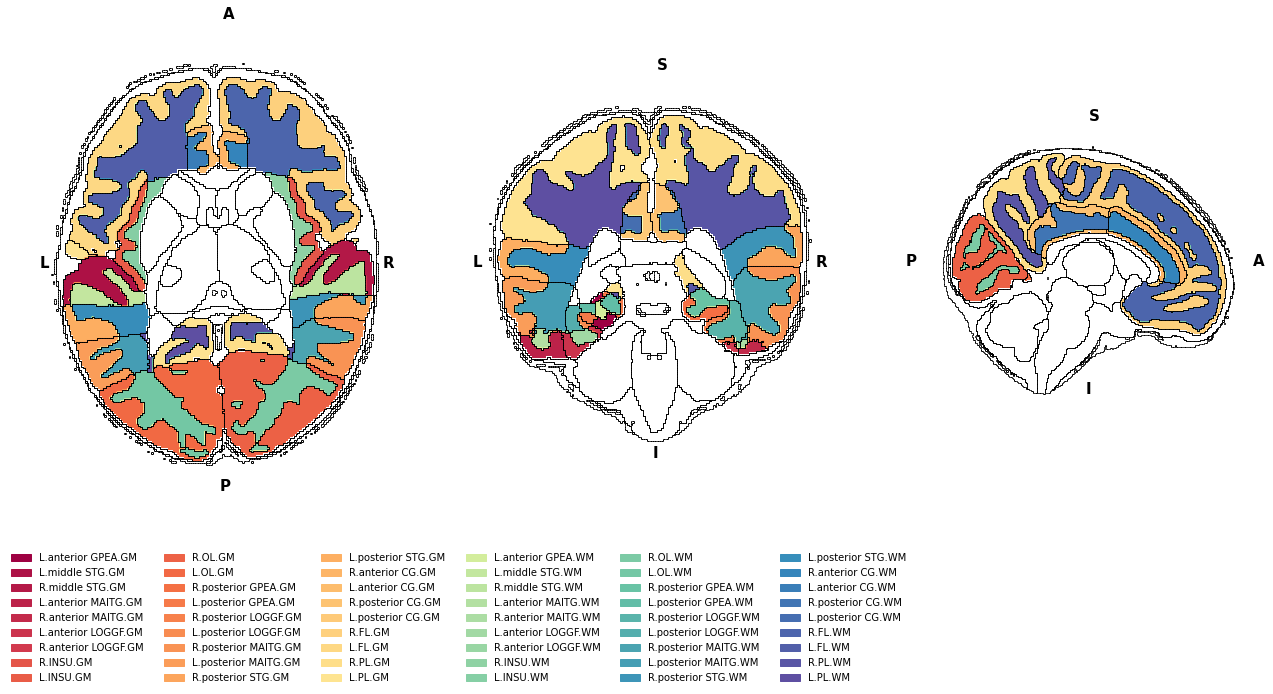

In [11]:
fig,map_view_dict_Imperial = visualisation.Brainmap.plot_segmentation(map_view=['all'],regions_to_hide=deep_grey_matter_labels+lateral_ventricles_labels+brainstem_labels+csf_labels+background_labels+corpus_callosum_labels+cerebellum_labels,label_legend=label_legend,atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',plot_orientation=True)
# fig.savefig('segmentation.svg',format='svg')

In [9]:
label_legend={label:value['Name_and_matter'] for label,value in Imperial_label_dict.items()}

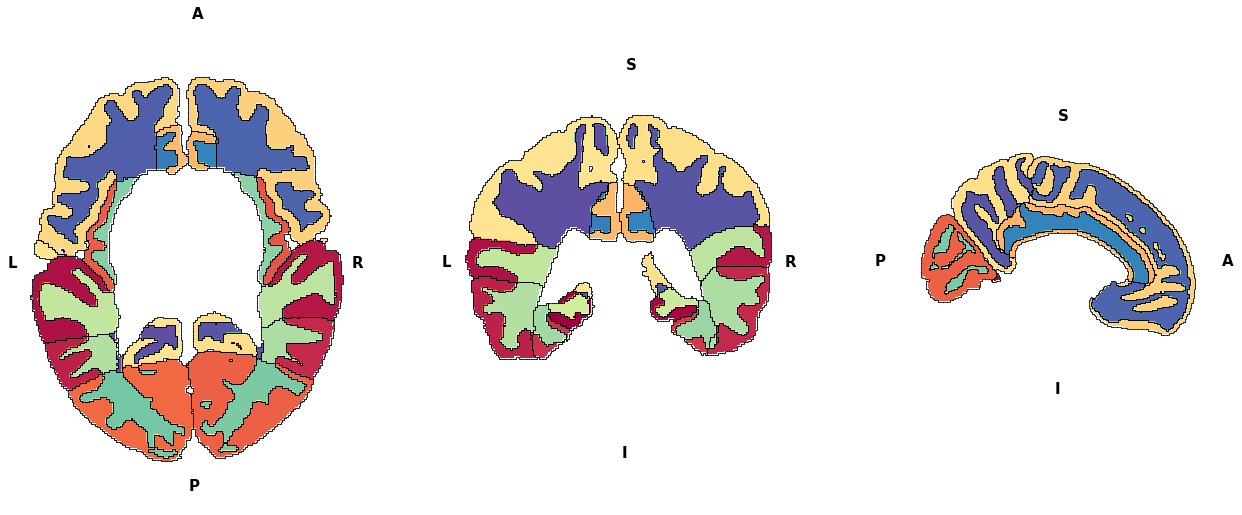

In [13]:
fig,map_view_dict_Imperial = visualisation.Brainmap.plot_segmentation(map_view=['all'],
                                                                      regions_to_hide=deep_grey_matter_labels+lateral_ventricles_labels+brainstem_labels+csf_labels+background_labels+corpus_callosum_labels+cerebellum_labels,
                                                                      label_legend=label_legend,legends=False,atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',plot_orientation=True)
fig.savefig('combined_segmentation.svg',format='svg')

## AAL atlas

In [5]:
AAL_label = pd.read_excel(open(
    f'{dataset_path}/volumetric/full_dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx',
    'rb'),
                               sheet_name='AAL LEGEND',
                               header=None,names=['AAL_index','AAL_abbrv'])
# Imperial_label.to_csv('./Imperial_label.txt',index=False,header=False)

In [6]:
AAL_label['abbrv'] = AAL_label['AAL_abbrv'].apply(lambda x: x.split(' ')[1].replace("'",''))
AAL_label['index'] = AAL_label['AAL_index'].apply(lambda x: int(x.replace('AAL ','')))

In [7]:
AAL_label_dict = dict((AAL_label[['index','abbrv']].values))

In [8]:
atlas_file = nib.load('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')

In [9]:
AAL_label_dict[109] = 'Vermis'

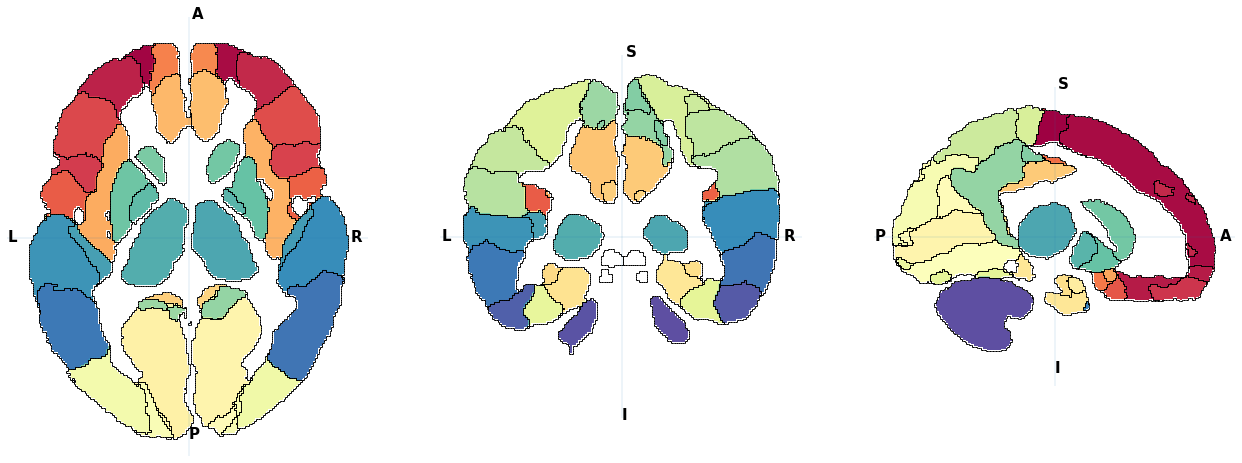

In [20]:
fig,map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['all'],plot_values={i:i for i,v in AAL_label_dict.items()},atlas_slice={'sagittal':120},atlas_file=atlas_file,cmap='Spectral')